In [1]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
import sys
import os
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(base_dir)
from augmentation_generator_batch_size import *
from custom_transformers import *

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## FashionMnist data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


## Soft labels rounded demo

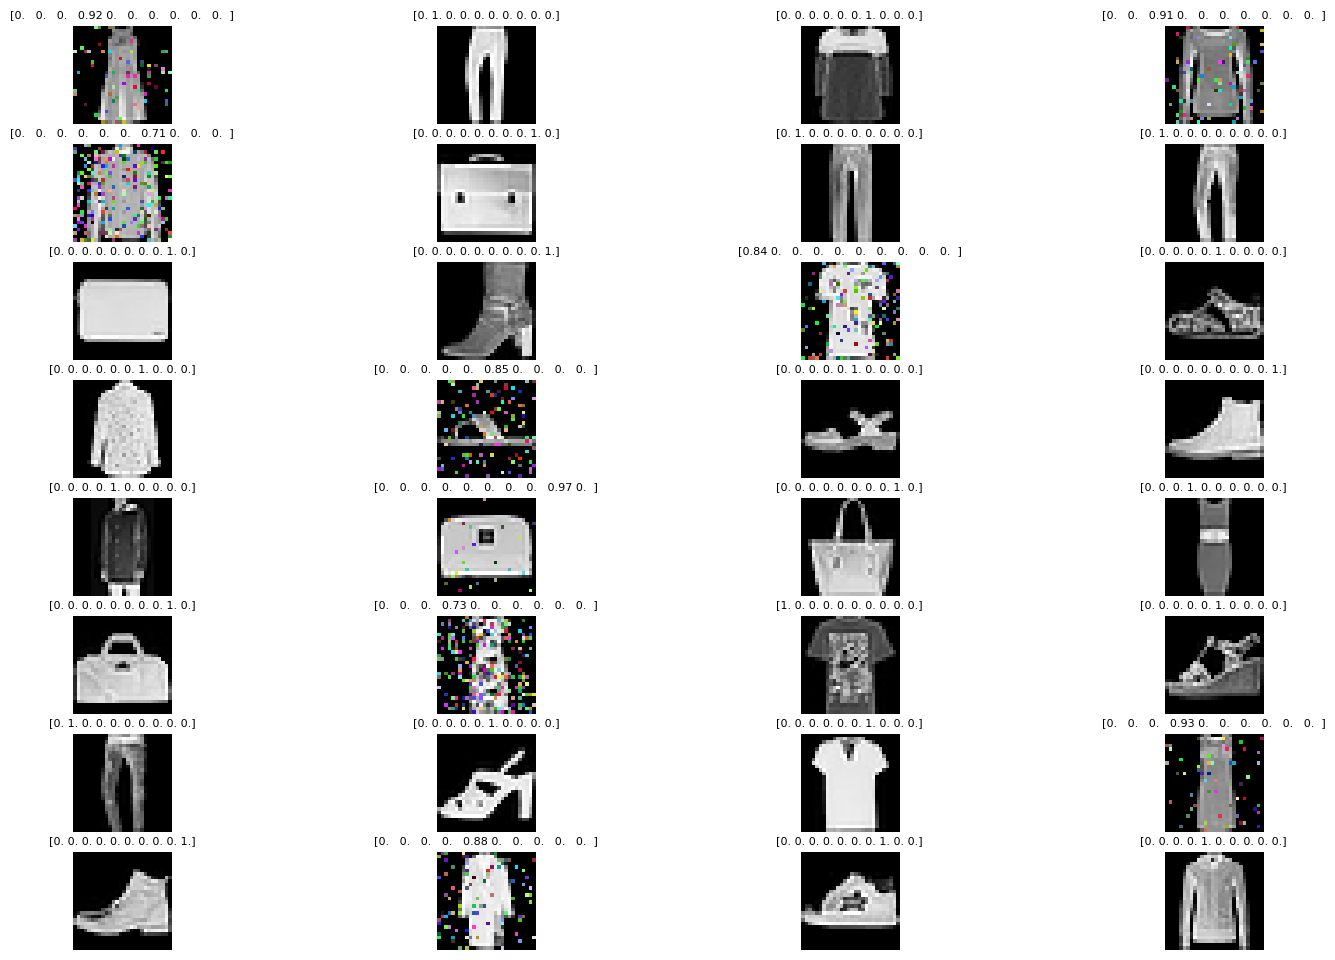

In [4]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= pixel_cutout, augment_fraction=0.5, overwrite=False, soft_label=True)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Random Pixels cutout with rounded labels
Max size =0.05

In [5]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.05, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.8140 - loss: 0.5707 - val_accuracy: 0.8156 - val_loss: 0.5876
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7988 - loss: 8.4425 - val_accuracy: 0.7531 - val_loss: 5.8688
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6898 - loss: 210.2244 - val_accuracy: 0.6213 - val_loss: 26.6713
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.6721 - loss: 1011.8772 - val_accuracy: 0.7900 - val_loss: 68.5372
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6817 - loss: 2635.4622 - val_accuracy: 0.7316 - val_loss: 314.5770
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6773 - loss: 6018.5410 - val_accuracy: 0.6740 - val_loss: 1310.4391


In [7]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.61      0.94      0.74      1000
           1       0.99      0.96      0.98      1000
           2       0.98      0.04      0.09      1000
           3       0.92      0.81      0.86      1000
           4       0.38      0.97      0.55      1000
           5       0.99      0.92      0.95      1000
           6       1.00      0.01      0.01      1000
           7       1.00      0.12      0.21      1000
           8       0.93      0.97      0.95      1000
           9       0.51      0.99      0.68      1000

    accuracy                           0.67     10000
   macro avg       0.83      0.67      0.60     10000
weighted avg       0.83      0.67      0.60     10000



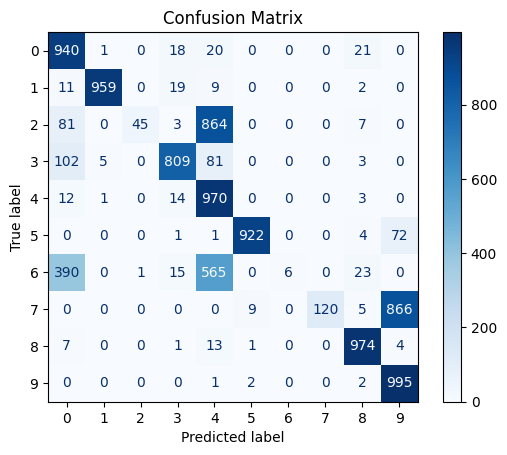

In [8]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Final Training Accuracy: 0.6804
Final Validation Accuracy: 0.6740


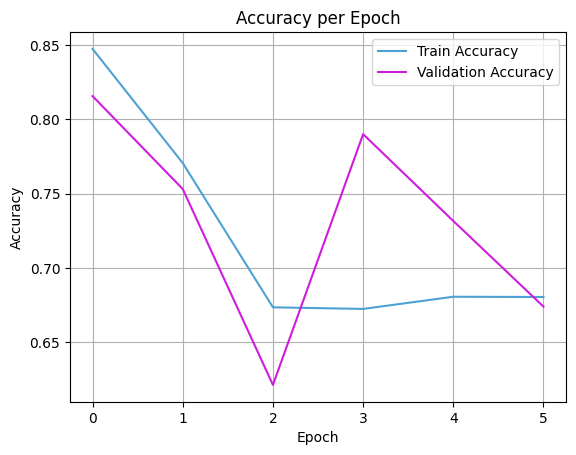

In [9]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

## Random squares cutout with rounded labels

In [15]:
squares_cutout = RandomSquaresCutout(max_number_of_squares=10, max_size_ratio=0.05)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=squares_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.8197 - loss: 0.5709 - val_accuracy: 0.8773 - val_loss: 0.3394
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9024 - loss: 0.2687 - val_accuracy: 0.8908 - val_loss: 0.3064
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9052 - loss: 0.2836 - val_accuracy: 0.8872 - val_loss: 0.3498
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8892 - loss: 0.4786 - val_accuracy: 0.8817 - val_loss: 1.1610
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8669 - loss: 0.9559 - val_accuracy: 0.8713 - val_loss: 0.6865
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8644 - loss: 1.4499 - val_accuracy: 0.8328 - val_loss: 2.6448


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Final Training Accuracy: 0.8558
Final Validation Accuracy: 0.8328


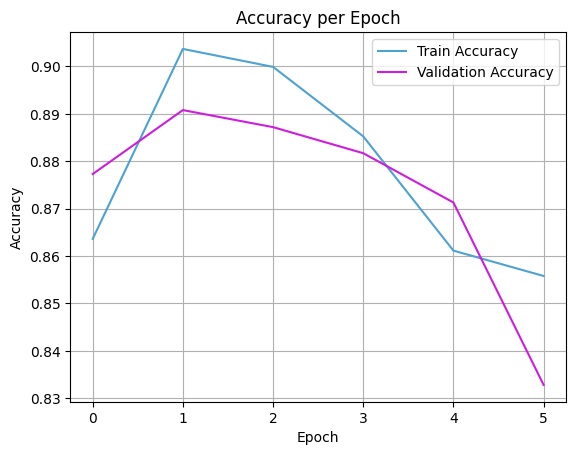

In [16]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()


## Square cutout with rounded labels

In [12]:
square_cutout = SquareCutout(size=5, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=square_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.8134 - loss: 0.5888 - val_accuracy: 0.8809 - val_loss: 0.3214
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9032 - loss: 0.2685 - val_accuracy: 0.9043 - val_loss: 0.2665
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9210 - loss: 0.2162 - val_accuracy: 0.9141 - val_loss: 0.2420
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9286 - loss: 0.1944 - val_accuracy: 0.9188 - val_loss: 0.2313
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9405 - loss: 0.1612 - val_accuracy: 0.9127 - val_loss: 0.2508
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9495 - loss: 0.1370 - val_accuracy: 0.9239 - val_loss: 0.2387


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Final Training Accuracy: 0.9485
Final Validation Accuracy: 0.9239


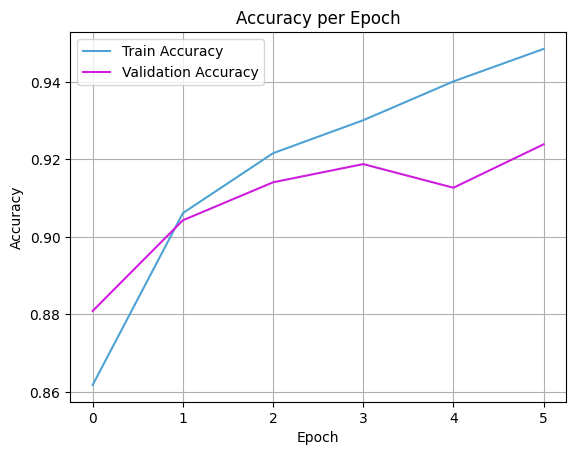

In [13]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()


## Random squares but 0.02 frac

In [19]:
pixel_cutout = RandomPixelCutout(max_cutout_size=0.02, color=False)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=pixel_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
  train_generator, validation_data=test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8141 - loss: 0.5845 - val_accuracy: 0.8958 - val_loss: 0.2908
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9047 - loss: 0.2645 - val_accuracy: 0.8665 - val_loss: 0.3941
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9046 - loss: 0.2889 - val_accuracy: 0.8823 - val_loss: 0.5893
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8931 - loss: 0.4808 - val_accuracy: 0.8873 - val_loss: 0.4762
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8650 - loss: 1.2619 - val_accuracy: 0.8463 - val_loss: 1.9713
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8456 - loss: 3.6443 - val_accuracy: 0.8007 - val_loss: 4.3665


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Final Training Accuracy: 0.8331
Final Validation Accuracy: 0.8007


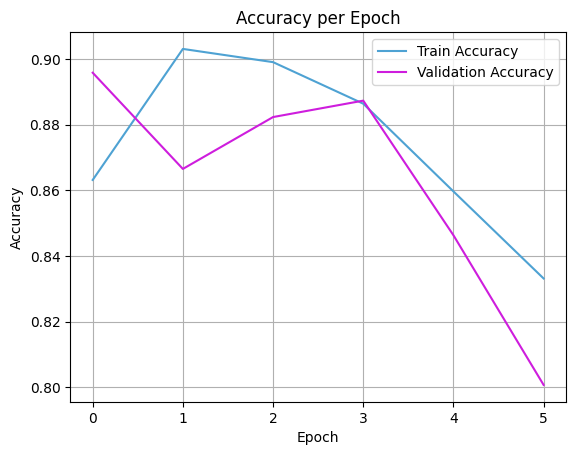

In [20]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()